In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import datetime
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [21]:
data=pd.read_csv("https://raw.githubusercontent.com/Aathira123/DataFile/main/netflix-stock.csv")


In [22]:
data.head(12)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
1,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
3,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
4,2002-05-31,1.078571,1.078571,1.071429,1.076429,1.076429,8464400
5,2002-06-03,1.080000,1.149286,1.076429,1.128571,1.128571,3151400
6,2002-06-04,1.135714,1.140000,1.110714,1.117857,1.117857,3105200
7,2002-06-05,1.110714,1.159286,1.107143,1.147143,1.147143,1531600
8,2002-06-06,1.150000,1.232143,1.148571,1.182143,1.182143,2305800
9,2002-06-07,1.177857,1.177857,1.103571,1.118571,1.118571,1369200


In [23]:
data.shape

(5163, 7)

Check if the dataset contains null values and we can see it contains no nullvalues

In [24]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Lets add a new column called "year" from the date column

In [25]:
splitted = data['Date'].str.split('-', expand=True)
data['year'] = splitted[0].astype('int')

We can group the data based on year and plot its mean as a bar plot

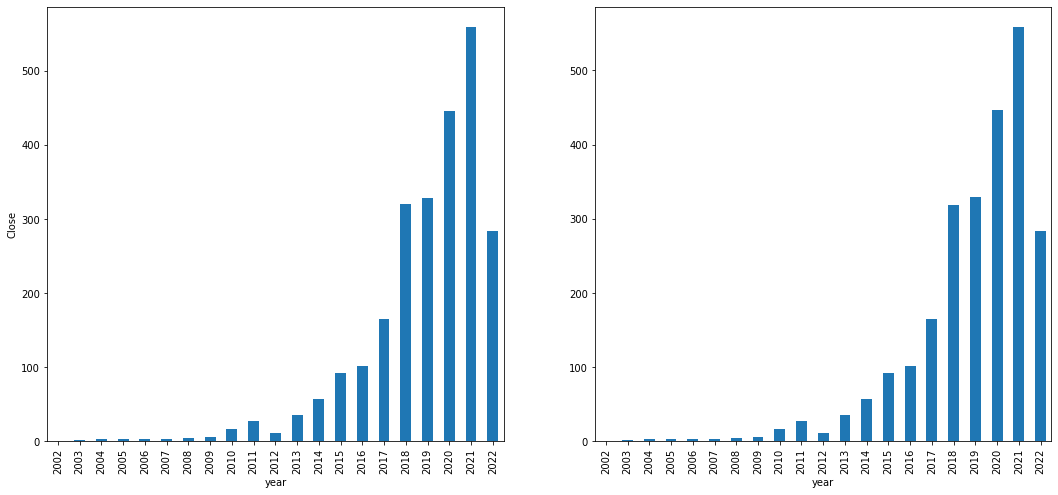

In [26]:
yeared_data = data.groupby('year').mean()
plt.subplots(figsize=(18,8))
for i, col in enumerate(['Open', 'Close']):
  plt.ylabel(col)
  plt.xlabel("year")
  plt.subplot(1,2,i+1)
  yeared_data[col].plot.bar()
plt.show()


As we can see , The stock price is the highest in the year 2021.After 2021 there is a huge drop in the stock price of netflix.
We reduce our dataframe to contain the date and closing price for a particular day and we will from further on use closing price to give to our model for prediction

In [27]:

df=data[['Date','Close']]

Checking the datatype of Date and Close

In [28]:
df.dtypes

Date      object
Close    float64
dtype: object

We need to convert Date into datetime format as it is currently stored as object dtype

In [29]:
df['Date']= pd.to_datetime(df['Date'])
df.dtypes

<ipython-input-29-612777657fb8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']= pd.to_datetime(df['Date'])


Date     datetime64[ns]
Close           float64
dtype: object

Setting Date as our Index for the dataframe

In [30]:
df.set_index('Date',inplace=True)

**Visualising the closing price throughout the years.**

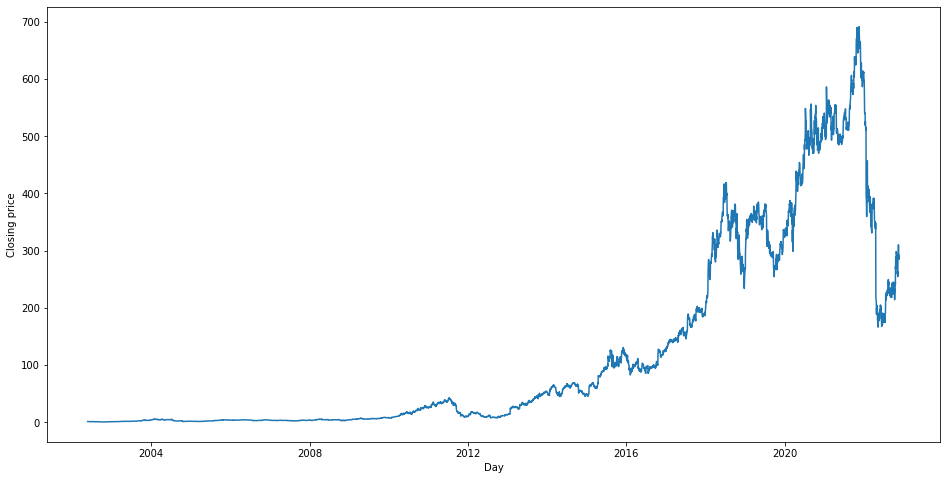

In [31]:
plt.figure(figsize=(16,8))
plt.xlabel("Day")
plt.ylabel("Closing price")
plt.plot(df.index,df.Close)
plt.show()

As we can see from the graph , there is a steep increase in the stock price from 2016.But After 2020 there is a sudden drop in the price.
We need to have a target column for the model to predict. For this reason , for each date , we add a target column which is the closing price for that day and additionally we add n number of columns which is the closing price of the stock for (currentday-i)th day where i ranges from 1 to n. In our project we will use n=10. This way our problem became a supervised learning problem with 10 feature column and 1 target.

In [32]:
def create_new_df(frame, startdate, enddate, n):
  startdate = pd.to_datetime(startdate)
  enddate  = pd.to_datetime(enddate)
  date_iter = startdate
  dates = []
  prev_prices=[]
  curr_day_price=[]
  lastdate=False
  while True:
    df_subset = frame.loc[:date_iter]
    df_subset=df_subset.tail(n+1)
    dates.append(date_iter)
    close_values = df_subset['Close'].to_numpy()
    prev_prices.append(close_values[:-1])
    curr_day_price.append(close_values[-1])
    if(date_iter==enddate):
      break
    #From current date , get subset of dataframe upto one week
    weekly_df = frame.loc[date_iter:date_iter+datetime.timedelta(days=7)]
    #Then from the subset dataframe we select the second row
    nextrow=weekly_df.iloc[[1]]
    dateWithTime = nextrow.index.values[0]
    nextDate = str(dateWithTime).split('T')[0].split('-')
    year = nextDate[0]
    month=nextDate[1]
    day=nextDate[2]
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    date_iter = next_date
    
  updated_df = pd.DataFrame({})
  updated_df['Date'] = dates
  for i in range(0, n):
    updated_df[f'{n-i}thDayPrice'] = np.asarray(prev_prices)[:, i]
  updated_df['Closing_Price'] = curr_day_price
  return updated_df

In [33]:
new_df = create_new_df(df,'2002-06-10', '2022-10-28', n=10)
new_df

,Date,10thDayPrice,9thDayPrice,8thDayPrice,7thDayPrice,6thDayPrice,5thDayPrice,4thDayPrice,3thDayPrice,2thDayPrice,1thDayPrice,Closing_Price
0,2002-06-10,1.210000,1.157143,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571,1.156429
1,2002-06-11,1.157143,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571,1.156429,1.153571
2,2002-06-12,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571,1.156429,1.153571,1.092857
3,2002-06-13,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571,1.156429,1.153571,1.092857,1.082857
4,2002-06-14,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571,1.156429,1.153571,1.092857,1.082857,0.986429
...,...,...,...,...,...,...,...,...,...,...,...,...
5130,2022-10-24,229.979996,214.289993,220.869995,232.509995,230.000000,245.100006,240.860001,272.380005,268.160004,289.570007,282.450012
5131,2022-10-25,214.289993,220.869995,232.509995,230.000000,245.100006,240.860001,272.380005,268.160004,289.570007,282.450012,291.019989
5132,2022-10-26,220.869995,232.509995,230.000000,245.100006,240.860001,272.380005,268.160004,289.570007,282.450012,291.019989,298.619995
5133,2022-10-27,232.509995,230.000000,245.100006,240.860001,272.380005,268.160004,289.570007,282.450012,291.019989,298.619995,296.940002


Our closing prices have a wide range of values . We scale them to a range of 0 to 1.

In [34]:
scaler = MinMaxScaler()
for cols in new_df.columns[1:]:
  new_df[cols]=scaler.fit_transform(new_df[[cols]])

In [35]:
#convert our dataframe to numpy array
def windowed_df_date_input_output(new_df):
  new_df1=new_df.to_numpy()
  target_before_column=new_df1[:,0:-1]
  X=target_before_column
  Y=new_df1[:,-1]
  return X,Y.astype(np.float32)

In [36]:
X,y=windowed_df_date_input_output(new_df)

In [37]:
X_train,X_test,y_train, y_test = train_test_split(X,y, train_size=0.8)

We need to remove the Date column from X_train and X_test. For that we do the following.

In [38]:
X_train1=[]
X_test1=[]
for ele in X_train:
  X_train1.append(ele[1:])
for ele in X_test:
  X_test1.append(ele[1:]) 
X_train1=np.asarray(X_train1).astype(np.float32)
#Converting from 2D to 3D
X_train1=X_train1.reshape(X_train1.shape[0],X_train1.shape[1],1)
X_test1=np.asarray(X_test1).astype(np.float32)
X_test1=X_test1.reshape(X_test1.shape[0],X_test1.shape[1],1)

In [39]:

class LSTM1:
    
    def state_initialise(self,no_of_neurons,n_cells):
        self.forgetState = list(np.zeros((n_cells,no_of_neurons,1)))
        self.inputState = list(np.zeros((n_cells,no_of_neurons,1)))
        self.candidateState = list(np.zeros((n_cells,no_of_neurons,1)))
        self.cellState = list(np.zeros((n_cells,no_of_neurons,1)))
        self.op_state = list(np.zeros((n_cells,no_of_neurons,1)))
        self.hiddenState = list(np.zeros((n_cells,no_of_neurons,1)))
    def weight_bias_initialise(self,no_of_neurons,n_cells):
        #To randomely initiliase weights-xavier initialisation
        lower, upper = -(1.0 / np.sqrt(n_cells)), (1.0 / np.sqrt(n_cells))
        # weights to forget gate , input gate,output gate and cell state
        self.forget_weight = lower+np.random.random((no_of_neurons, 1+ no_of_neurons))*(upper-lower)
        self.input_weight = lower+np.random.random((no_of_neurons, 1 + no_of_neurons))*(upper-lower)
        self.cell_weight = lower+np.random.random((no_of_neurons, 1 + no_of_neurons))*(upper-lower)
        self.output_weight = lower+np.random.random((no_of_neurons, 1 + no_of_neurons))*(upper-lower)
        # bias of forget gate,input gate, cell state and output gate     
        self.forget_bias = lower+np.random.random((no_of_neurons, 1))*(upper-lower)
        self.input_bias = lower+np.random.random((no_of_neurons, 1))*(upper-lower)
        self.cell_bias = lower+np.random.random((no_of_neurons, 1))*(upper-lower)
        self.output_bias = lower+np.random.random((no_of_neurons, 1))*(upper-lower)
        
        # The last/final output weight and bias
        self.last_weight = lower+np.random.random((1, no_of_neurons))*(upper-lower)
        self.last_bias= lower+np.random.random((1, 1))*(upper-lower)

    # To create LSTM model , we pass the learning rate , Number of cells and neurons
    def __init__(self, n_hidden, n_cells, lr_rate):
    
        # No of neurons in a LSTM layer
        self.no_of_neurons = n_hidden
        # No. of lstm cells
        self.n_cells = n_cells 
        # learning rate
        self.lr_rate = lr_rate
        self.state_initialise(n_hidden,n_cells)
        self.weight_bias_initialise(n_hidden,n_cells)
            
    def forward_propagationFn(self, x):
        for k in range(1, self.n_cells):
            fstate = self.sigmoidFn(np.matmul(self.forget_weight , np.concatenate((self.hiddenState[k-1],x[k].reshape(-1,1)),axis=0)) + self.forget_bias)
            istate = self.sigmoidFn(np.matmul(self.input_weight , np.concatenate((self.hiddenState[k-1],x[k].reshape(-1,1)),axis=0)) + self.input_bias)
            ostate= self.sigmoidFn(np.matmul(self.output_weight , np.concatenate((self.hiddenState[k-1], x[k].reshape(-1,1)),axis=0)) + self.output_bias)
            candstate = self.tanhFn(np.matmul(self.cell_weight, np.concatenate((self.hiddenState[k-1],x[k].reshape(-1,1)),axis=0)) + self.cell_bias)
            internalstate = self.cellState[k-1]*fstate + istate*candstate
            hidstate = self.tanhFn(internalstate)*ostate
            self.forgetState[k] = fstate
            self.inputState[k] = istate
            self.candidateState[k] = candstate
            self.cellState[k] = internalstate     
            self.op_state[k] = ostate
            self.hiddenState[k] = hidstate
        #Weight to the final output neuron multiplied with the last neuron's input and bias added   
        y_predicted = self.last_weight @ self.hiddenState[-1] + self.last_bias
        return y_predicted
    def backpropagationFn(self, y_true, y_pred,x):


        forgetStateDelta = list(np.zeros((self.n_cells,self.no_of_neurons,1)))
        inputStateDelta = list(np.zeros((self.n_cells,self.no_of_neurons,1)))
        candidateStateDelta = list(np.zeros((self.n_cells,self.no_of_neurons,1)))
        cellStateDelta = list(np.zeros((self.n_cells,self.no_of_neurons,1)))
        outputStateDelta = list(np.zeros((self.n_cells,self.no_of_neurons,1)))
        hiddenStateDelta = list(np.zeros((self.n_cells,self.no_of_neurons,1)))

        gradient_output_weight = np.zeros((self.no_of_neurons, 1+ self.no_of_neurons))
        gradient_output_bias = np.zeros((self.no_of_neurons, 1))
        gradient_input_weight = np.zeros((self.no_of_neurons, 1+ self.no_of_neurons))
        gradient_input_bias = np.zeros((self.no_of_neurons, 1))
        gradient_forget_weight = np.zeros((self.no_of_neurons, 1+ self.no_of_neurons))
        gradient_forget_bias = np.zeros((self.no_of_neurons, 1))
        gradient_cell_bias = np.zeros_like(a = self.cell_bias)    
        gradient_cell_weight = np.zeros((self.no_of_neurons, 1+ self.no_of_neurons))
        gradient_last_weight = np.zeros((1, self.no_of_neurons))
        gradient_final_bias = np.zeros((1,1)) 
        true_pred_diff = y_true - y_pred
        gradient_final_bias = true_pred_diff 
        gradient_last_weight = true_pred_diff * self.hiddenState[-1].T
        

        for t in reversed(range(self.n_cells-1)):

            hiddenStateDelta[t] = self.last_weight.T @ true_pred_diff + hiddenStateDelta[t+1]
            cellStateDelta[t] =  hiddenStateDelta[t] * self.op_state[t]  * 1-(self.tanhFn(self.cellState[t]))**2 + cellStateDelta[t+1]*self.forgetState[t+1]
            candidateStateDelta[t] = cellStateDelta[t] * self.inputState[t]  * 1-(self.candidateState[t])**2
            inputStateDelta[t] = cellStateDelta[t] *self.candidateState[t] * self.inputState[t] * (1- self.inputState[t])
            forgetStateDelta[t] = cellStateDelta[t]  * self.cellState[t-1] * self.forgetState[t]*(1-self.forgetState[t])
            outputStateDelta[t] = hiddenStateDelta[t] * self.tanhFn(self.cellState[t]) * self.op_state[t]*(1-self.op_state[t])
            xt = np.concatenate((self.hiddenState[t-1], x[t].reshape(-1,1)),axis=0)
            
            gradient_forget_weight +=forgetStateDelta[t] @ xt.T
            gradient_input_weight += np.matmul(inputStateDelta[t] , xt.T)
            gradient_cell_weight += np.matmul(cellStateDelta[t] ,xt.T)
            gradient_output_weight += np.matmul(outputStateDelta[t], xt.T)
            gradient_input_bias += inputStateDelta[t]
            gradient_forget_bias += forgetStateDelta[t]
            gradient_output_bias += outputStateDelta[t]
            gradient_cell_bias += cellStateDelta[t]            

        return gradient_last_weight, gradient_final_bias, gradient_forget_weight, gradient_forget_bias, gradient_input_weight, gradient_input_bias, gradient_output_weight, gradient_output_bias, gradient_cell_weight, gradient_cell_bias

    def rmseFn(self,y_true,y_predicted):
      numlis=[]
      y_true=list(y_true)
      for i in range(len(y_true)):
        numlis.append((y_true[i]-y_predicted[i])**2)
      return np.sqrt(sum(numlis)/len(y_true))
    def R2_score(self,y_true,y_predicted):
      y_true=list(y_true)
      numlis=[]
      for i in range(len(y_true)):
        numlis.append((y_true[i]-y_predicted[i])**2)

      return 1-(sum(numlis)/len(y_true))   
    # Function to train       
    def fit(self, epochs, x, actual_y):
        y_aveg= sum(list(actual_y))/len(actual_y)
        for e in range(epochs):
            training_loss_per_epoch = 0 
            num_list=[]
            denom_list=[]
            y_list=[]
            for i in range(len(x)):
            
                y_pred = self.forward_propagationFn(x[i])
                y_list.append(y_pred)
                gradient_last_weight, gradient_final_bias, gradient_forget_weight, gradient_forget_bias, gradient_input_weight, gradient_input_bias, gradient_output_weight, gradient_output_bias, gradient_cell_weight, gradient_cell_bias = self.backpropagationFn(actual_y[i], y_pred,x[i])
                self.forget_weight = self.forget_weight + self.lr_rate * gradient_forget_weight/self.n_cells
                self.input_weight = self.input_weight + self.lr_rate * gradient_input_weight/self.n_cells
                self.cell_weight = self.cell_weight + self.lr_rate * gradient_cell_weight/self.n_cells
                self.output_weight = self.output_weight + self.lr_rate * gradient_output_weight/self.n_cells
                self.forget_bias = self.forget_bias + self.lr_rate * gradient_forget_bias/self.n_cells
                self.input_bias = self.input_bias + self.lr_rate * gradient_input_bias/self.n_cells
                self.cell_bias = self.cell_bias + self.lr_rate * gradient_cell_bias/self.n_cells
                self.output_bias = self.output_bias + self.lr_rate * gradient_output_bias /self.n_cells               
                self.last_bias = self.last_bias + self.lr_rate * gradient_final_bias 
                self.last_weight = self.last_weight + self.lr_rate * gradient_last_weight
                training_loss_per_epoch += ((actual_y[i] - y_pred)**2)/2
                num_list.append((actual_y[i]-y_pred)**2)
                denom_list.append((y_pred-y_aveg)**2)

            r2score= self.R2_score(actual_y,y_list)
            rmse=self.rmseFn(actual_y,y_list)
            print("Epoch: " ,e, " Training loss: ", (training_loss_per_epoch/len(x))[0][0], " r2 Score: ", r2score," RMSE: ", rmse)
            
          
    
    def predict(self, x_test):         
        prediction = []
        for i in range(len(x_test)):
            pr= self.forward_propagationFn(x_test[i]) 
            prediction.append(pr)            
        return prediction
    
    #Sigmoid and Tanh Activation function defined below
    def sigmoidFn(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanhFn(self, x):
        return np.tanh(x)



In [41]:
n_inputs = 10
n_outputs = 1
no_neurons = 15
n_epochs =10
learning_rate=0.05
lstm = LSTM1(no_neurons,n_inputs, learning_rate)
lstm.fit(n_epochs , X_train1, y_train)


Epoch:  0  Training loss:  0.02856618435023213  r2 Score:  [[0.94286763]]  RMSE:  [[0.23902378]]
Epoch:  1  Training loss:  0.021841586339367693  r2 Score:  [[0.95631683]]  RMSE:  [[0.2090052]]
Epoch:  2  Training loss:  0.020459110255561075  r2 Score:  [[0.95908178]]  RMSE:  [[0.20228253]]
Epoch:  3  Training loss:  0.018445854017850833  r2 Score:  [[0.96310829]]  RMSE:  [[0.19207214]]
Epoch:  4  Training loss:  0.023037662127060557  r2 Score:  [[0.95392468]]  RMSE:  [[0.21465163]]
Epoch:  5  Training loss:  0.02555586455570927  r2 Score:  [[0.94888827]]  RMSE:  [[0.22607903]]
Epoch:  6  Training loss:  0.024032710067748504  r2 Score:  [[0.95193458]]  RMSE:  [[0.21923827]]
Epoch:  7  Training loss:  0.02209885028580466  r2 Score:  [[0.9558023]]  RMSE:  [[0.21023249]]
Epoch:  8  Training loss:  0.020078287806176903  r2 Score:  [[0.95984342]]  RMSE:  [[0.20039106]]
Epoch:  9  Training loss:  0.01796614629715228  r2 Score:  [[0.96406771]]  RMSE:  [[0.18955815]]


In [42]:
trainingPred=np.concatenate(lstm.predict(X_train1)) 
y_test_pred = np.concatenate(lstm.predict(X_test1))

In [43]:

print("R2 score of train set",lstm.R2_score(list(y_train),list(trainingPred))[0])
print("RMSE of train set",lstm.rmseFn(list(y_train),list(trainingPred))[0]) 
print("R2 score of test set", lstm.R2_score(list(y_test),list(y_test_pred))[0])
print("RMSE of test set",lstm.rmseFn(list(y_test),list(y_test_pred))[0])

R2 score of train set 0.9663405010760999
RMSE of train set 0.18346525263357114
R2 score of test set 0.9641532591731574
RMSE of test set 0.18933235546742294


In [45]:
dates=X_test[:,0]

Concatenate date with the actual and predicted y value and create a dataframe

In [46]:
newarr=np.concatenate((dates.reshape(-1,1),y_test.reshape(-1,1),y_test_pred),axis=1)



In [47]:
newdf1=pd.DataFrame(newarr,columns=["Date","Act_price","Pred_price"])

In [48]:

newdf1.set_index('Date',inplace=True)

Plotting the actual closing price with predicted closing price from test data

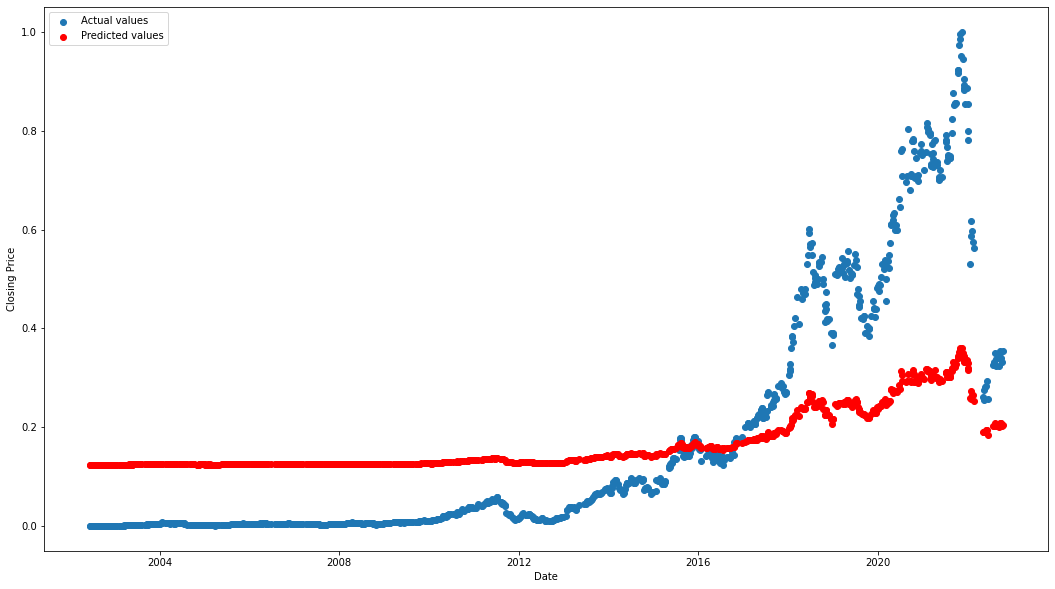

In [50]:
plt.figure(figsize=(18, 10))
plt.scatter(newdf1.index,newdf1["Act_price"], label='Actual values')
plt.scatter(newdf1.index,newdf1["Pred_price"],color="red", label='Predicted values')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()